<a href="https://colab.research.google.com/github/X57FI8W9S/TPPNL/blob/main/Desafio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

In [160]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [161]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/nirvana.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-1516256778.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,"Load up on guns, bring your friends"
1,It's fun to lose and to pretend
2,She's over-bored and self-assured
3,"Oh no, I know a dirty word Hello, hello, hello..."
4,"Hello, hello, hello, how low"


In [162]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1985


### 1 - Preprocesamiento

In [163]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

### 2 - Crear los vectores (word2vec)

In [164]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [165]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [166]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [167]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 1985


In [168]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 381


### 3 - Entrenar embeddings

In [169]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 97074.125
Loss after epoch 1: 50214.796875
Loss after epoch 2: 49106.203125
Loss after epoch 3: 49227.5625
Loss after epoch 4: 48495.03125
Loss after epoch 5: 47519.875
Loss after epoch 6: 46996.5
Loss after epoch 7: 46405.25
Loss after epoch 8: 45918.4375
Loss after epoch 9: 45943.65625
Loss after epoch 10: 44651.875
Loss after epoch 11: 43644.125
Loss after epoch 12: 43714.25
Loss after epoch 13: 42148.875
Loss after epoch 14: 42728.25
Loss after epoch 15: 41624.0
Loss after epoch 16: 40063.875
Loss after epoch 17: 40873.0
Loss after epoch 18: 39621.6875
Loss after epoch 19: 40518.4375


(130104, 246920)

### 4 - Ensayar

In [170]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["gun"], topn=10)

[('have', 0.8848908543586731),
 ('memoria', 0.8780661225318909),
 ('that', 0.8452708721160889),
 ('love', 0.8375701308250427),
 ('old', 0.8352569341659546),
 ('an', 0.7802321910858154),
 ('a', 0.7727643251419067),
 ('shoot', 0.7722331285476685),
 ('no', 0.7672722935676575),
 ('mulatto', 0.766625165939331)]

In [171]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["love"], topn=10)

[('married', 0.09585386514663696),
 ('night', -0.3440222144126892),
 ('ah', -0.3481104373931885),
 ('him', -0.36746853590011597),
 ('how', -0.3801831603050232),
 ('happy', -0.3802967369556427),
 ('hey', -0.383208692073822),
 ('hello', -0.38589590787887573),
 ('pines', -0.39500847458839417),
 ('low', -0.39550289511680603)]

In [172]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["mosquito"], topn=10)

[('libido', 0.9861789345741272),
 ('albino', 0.9847570061683655),
 ('mulatto', 0.9828996062278748),
 ('light', 0.9666252136230469),
 ('without', 0.9607694745063782),
 ('long', 0.9583695530891418),
 ('brother', 0.9573203921318054),
 ('found', 0.9534853100776672),
 ('mmm', 0.9485878944396973),
 ('fish', 0.9478883743286133)]

In [173]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["come"], topn=5)

[('over', 0.9154769778251648),
 ('eyes', 0.9102574586868286),
 ('old', 0.9005444645881653),
 ('friends', 0.8958324193954468),
 ("who's", 0.8945053815841675)]

In [174]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("love")
print(vector_love)

[ 0.02424175  0.2422208   0.07303016 -0.09598715  0.0482612  -0.00838865
  0.13163005  0.16541089 -0.21080801 -0.2842874   0.04428272 -0.24846552
  0.08619299 -0.10937504  0.04263388  0.00247536  0.14371966  0.05964346
 -0.250816   -0.0212865  -0.29124594  0.06960411  0.04753898  0.08166281
 -0.12298711 -0.14128697 -0.39570147  0.01763009  0.02242772 -0.16001248
  0.00912175  0.07541412  0.1050286  -0.01164625 -0.02401206  0.11325338
 -0.10644233 -0.18508624  0.04825399 -0.09245396  0.13412431 -0.10570859
 -0.10402934  0.0726903  -0.04503715  0.27490956  0.18640316  0.05431647
 -0.01460746  0.1638621   0.11748849  0.00276901  0.02917751  0.00962966
 -0.05262933  0.02172353  0.03205796 -0.00468611 -0.06782045 -0.17571537
 -0.0554024   0.03033859  0.0903189  -0.00716939  0.17624731  0.00882582
  0.12682655  0.0992452  -0.11398388 -0.11375657  0.05502455  0.23129962
  0.15248168 -0.07276959  0.07399355 -0.01385909 -0.07365326  0.04981099
  0.13552713  0.13574515 -0.08350762 -0.1105931   0

In [175]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)

[('love', 1.0),
 ('ask', 0.9150728583335876),
 ('buzz', 0.9060223698616028),
 ("don't", 0.8694254755973816),
 ('that', 0.8609623312950134),
 ('sunbeam', 0.8599412441253662),
 ('please', 0.8560247421264648),
 ('myself', 0.8505876064300537),
 ('makes', 0.8442907929420471),
 ('yea', 0.8420341610908508)]

In [176]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)

[('ask', 0.9150728583335876),
 ('buzz', 0.9060223698616028),
 ("don't", 0.8694254755973816),
 ('that', 0.8609623312950134),
 ('sunbeam', 0.8599412441253662),
 ('please', 0.8560247421264648),
 ('myself', 0.8505876064300537),
 ('makes', 0.8442907929420471),
 ('yea', 0.8420341610908508),
 ('jesus', 0.8405944108963013)]

### 5 - Visualizar agrupación de vectores

In [177]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [178]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

### Consigna del desafío 2

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado**

Recuerden que su notebook de entrega debe poder correrse de inicio a fin sin la aparición de errores.

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
- Elegir términos de interés y buscar términos más similares y menos similares.
- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

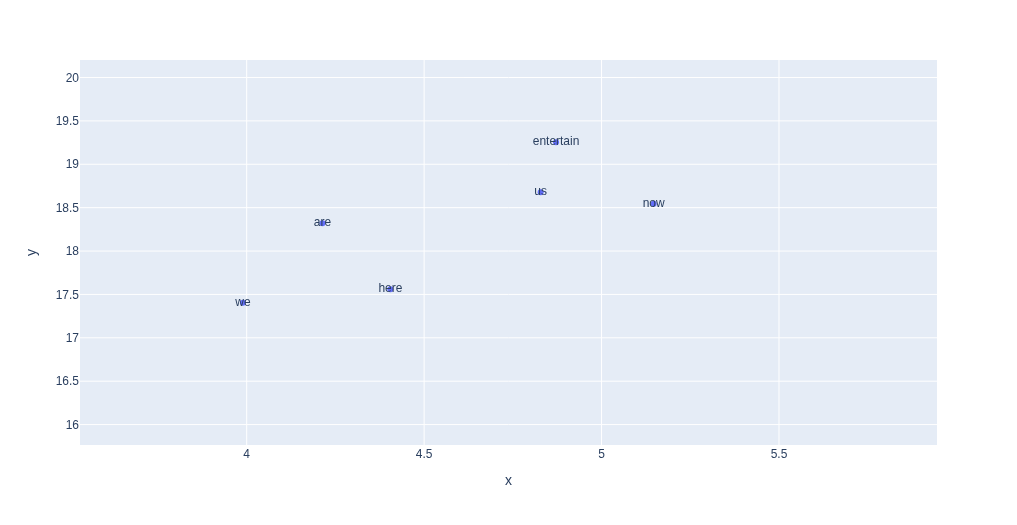

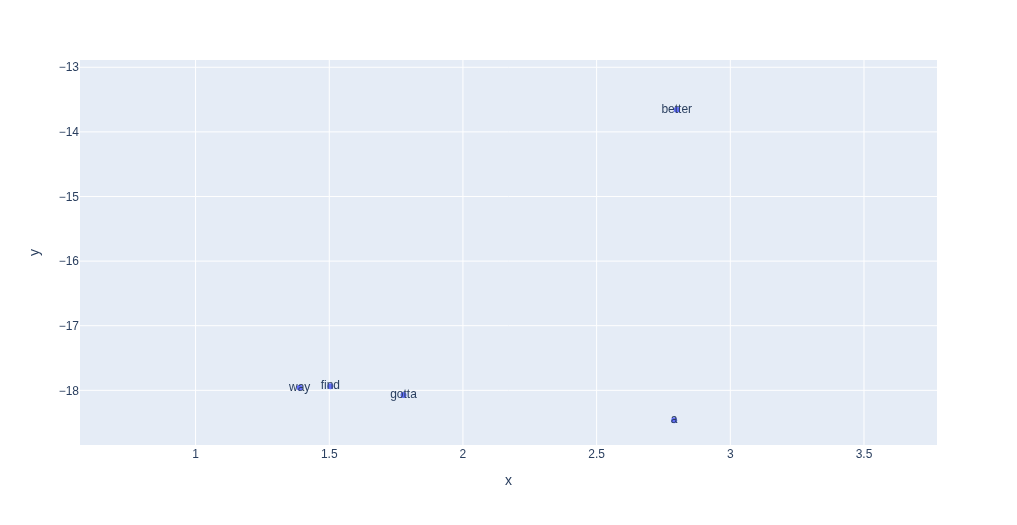

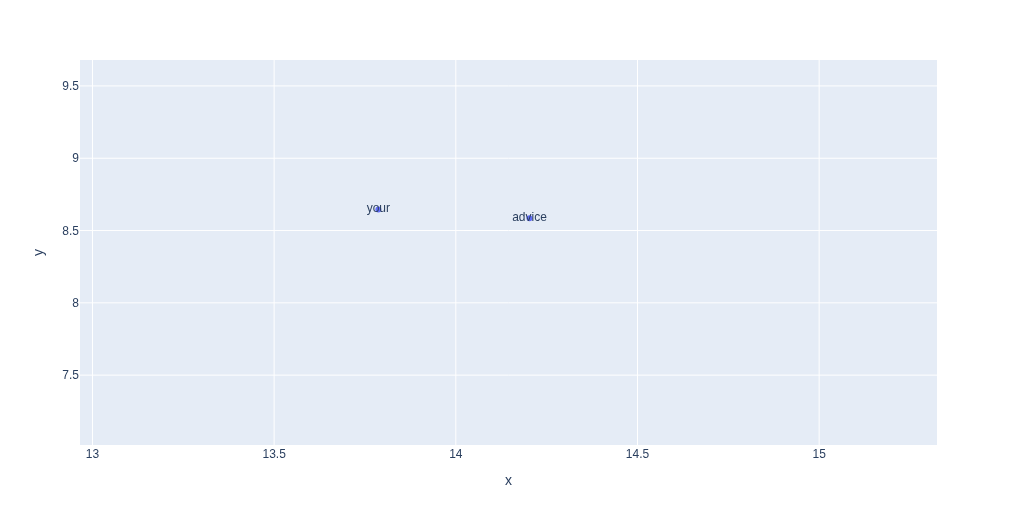